# The Dataset

The dataset includes a unique set of varying images of handwritten mathematical symbols based on student ID numbers.

My specific set includes a balanced dataset of 5000 images of 10 math sybmols:

## π, 7, +, 3, lim, cos, (, ÷, 9, 8.

# The Purpose (or Problem)

The goal of this assignment is to develop and evaluate two different ML classifiers:

*   Support Vector Machine (SVM)
*   Artifical Neural Network (ANN)

These classifiers will be used for a mathematical symbol classification task and their performance on extracted features to be compared.

The problem involves accurately classifying mathematical symbols using the following extracted features:

*   Raw Pixel Values - Direct pixel intensity from image
*   Histogram of Orientated Gradients (HOG) - Edge and shape information
*   Local Binary Patter (LBP) - Texture-based patterns.
*   Combination(s) of features






In [202]:
# Import the necessary libraries
from google.colab import drive
import glob
import cv2
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from skimage.color import rgb2gray
from skimage.feature import hog, local_binary_pattern as lbp
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

# Suppress annoying warnings to avoid unnecessary clutter
import warnings
warnings.filterwarnings("ignore")

In [203]:
# Mount Google Drive for access to dataset
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Unzips the zipped file to extract file contents
!unzip /content/drive/MyDrive/dataset_42028assg1_24923029.zip -d /content/data/

# Data loading & preparation (Preprocessing)

Here I load in the dataset and extract images and their corresponding labels to separate lists using OpenCV for image processing and glob for file handling. This approach ensures the data can be easily processed and matched during the modelling training and testing phases.

In [205]:
# Defines path to the dataset. '*' matches any subdirectories in file as all will be used.
path = '/content/data/*/*.jpg'

# Initialises lists to store image and label data
images = []
labels = []

# Loads the images
for file in glob.glob(path):
    img = cv2.imread(file) # Reads the images using OpenCV library
    images.append(img) # Appends the loaded image to the images list

# Saves the labels based on the folder names
for file in glob.glob(path):
    label = file.split('/') # Splits the file path by '/'
    label = label[-2] # Isolates the 2nd last element in the file path as the label
    labels.append(label) # Appends the label to the labels list

# Converts the lists to numpy arrays
X = np.array(images)
y = np.array(labels)

# Displaying data points for each category

Although unnecessary, here I display an image for each mathematical symbol in the dataset to get a better idea of what we're working with. From the display, we can discern that the images are small in size  (due to the observable pixels)and are black and white.

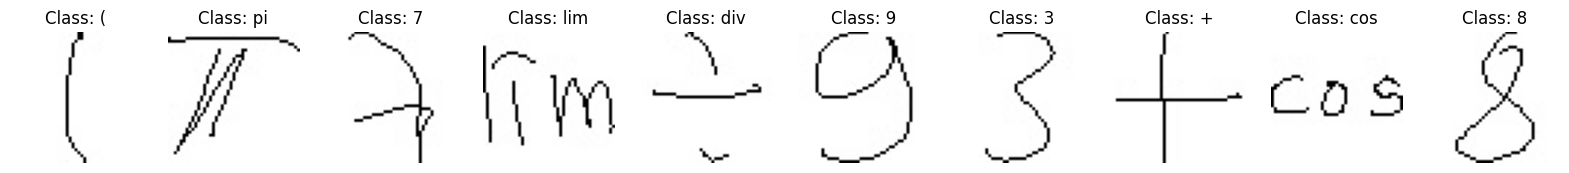

In [206]:
# Gets all unique labels in the y-array (labels list)
unique_labels = list(set(y))

# Initialises unique_images list to store a sample of each class of image
unique_images = []

# Loops over each unique label to find unique images
for label in unique_labels:
  for index in range(len(y)): # Loops through all labels in y
    if y[index] == label: # Condition to find matching labels
      unique_images.append(X[index]) # If a label matches, it will store the corresponding image from X to unique_images list
      break # After finding the first match, loop will break to avoid storing multiple images from the same class

# Creates row of subplots so images may be plotted side-by-side
fig, axes = plt.subplots(1, len(unique_images), figsize=(20, 4))

# Loops over each unique image and plots it with its corresponding label
for i in range(len(unique_images)):
    axes[i].imshow(unique_images[i])
    axes[i].set_title("Class: " + str(unique_labels[i]))
    axes[i].axis('off')
# Shows plot
plt.show()

# Test Train Split

Test-train split allows for the model to be training on the majority of the data (80%) while the rest can be used as unseen data to evaluate the model's performances. A 80-20 split was chosen as it's standard for a small dataset that only consists of 5000 images. A random state of 42 was chosen for reproducibility. Stratifying the dataset on the target variable was tested, however it resulted in a decrease in the model's performances.

In [207]:
# Splits the datasets (X, y) into training and testing splits.
# Test_size set to 0.2, meaning 20% of all the data will be allocated to the test data.
# Random_state set to 42 for result reproducibility
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Checking for imbalances in training dataset

Here I check for any imbalances in the dataset, however it was found that the dataset was fairly balanced already, requiring no data augmentation.

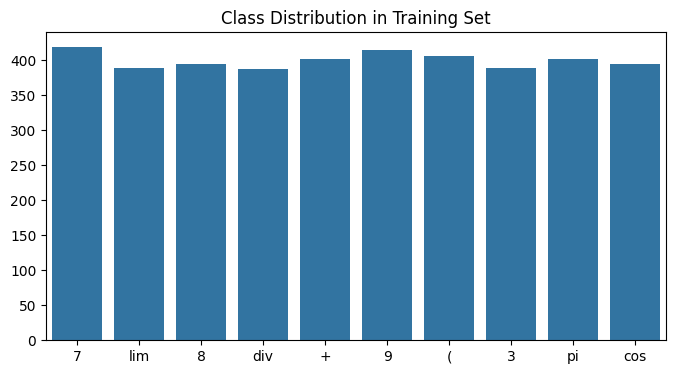

In [208]:
# Initialise empty dictionary to store class counts
label_counts = {}

# Loops over y_train to count the occurance of each label in the dataset
for i in range(len(y_train)):
    if y_train[i] in label_counts:
        label_counts[y_train[i]] += 1 # If label has already been found and added to label_counts dictionary then it will increment the count of that label
    else:
        label_counts[y_train[i]] = 1 # If new label is found it will be added to the dictionary and count will be set to 1

# Extracts keys and values (label and count) from the label_counts dictionary
unique_labels = list(label_counts.keys())
counts = list(label_counts.values())

# Plots class distribution found in training set (80% of all data)
plt.figure(figsize=(8, 4))
sns.barplot(x=unique_labels, y=counts)
plt.title('Class Distribution in Training Set')
plt.show()

# Encoding label data for model training

Using LabelEncoder() we convert the label data from categorical strings to integer labels. This was done because models like SVM and ANN cannot process categorical string labels direction, only numerical input. This was applied to both the training and testing set to ensure consistency.

In [209]:
# Initialises the LabelEncoder object from sklearn.preprocessing library
# LabelEncoder will convert categorical string labels in both training and test data labels to integer labels (i.e. pi --> 0, lim --> 1, cos --> 2, etc)
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Normalisating data

Normalising the data to ensure all of the input features are similar

*(Normalising the data saw a 10% increase in accuracy for all ANN models using Raw Pixels)*

In [210]:
# Normalise pixel values in the training and test sets to the range [0, 1]
X_train = X_train / 255.0
X_test = X_test / 255.0

# Extracting features

Here I extract the features using the skimage.feature library for easy feature extraction. I elected to use a library for that task as manually extracting the features resulted in a noticable decrease in accuracy for the ANN model.

## Reshaping image data for model compatibility

Reshaping the data from 3D to 2D arrays by flattening the images to get the raw pixels. This is necessary as the models require 2D inputs.

In [211]:
# Reshape training data into 2D arrays
X_train_raw = X_train.reshape(X_train.shape[0], -1)
X_test_raw = X_test.reshape(X_test.shape[0], -1)

### Extracting Histogram over gradient features from images

Here I extract the Histogram of Oriented Gradients (HOG) using the hog() and rgb2gray () methods from the images for training.  HOG is useful for capturing edge and gradient information which assists models to recognise shapes and patterns.

In [212]:
# Initialises empty lists to store HOG features for training and test data
X_train_hog = []
X_test_hog = []

# Loops through training images to extract HOG features
for i in X_train:
  X_train_hog.append(hog(rgb2gray(i))) # Appends converted 3D tensor to 2D grayscale image HOG features to X_train_hog list.
X_train_hog = np.array(X_train_hog) # After loop finishes, convert list to a numpy array

# Loops through testing images to extract HOG features
for i in X_test:
  X_test_hog.append(hog(rgb2gray(i))) # Appends HOG features to X_train_hog list
X_test_hog = np.array(X_test_hog) # After loop finishes, convert list to a numpy array

# Prints numpy array shape for training and testing data
print(f"HOG Feature shape (Train): {X_train_hog.shape}")
print(f"HOG Feature shape (Test): {X_test_hog.shape}")

HOG Feature shape (Train): (4000, 729)
HOG Feature shape (Test): (1000, 729)


### Extracting Local Binary Pattern features from images

Here I extract the Local Binary Pattern (LBP) using the lbp() and rgb2gray () methods from the images for training. It computes the LBP features based on the pixel intensity differences and then flattens them into 1D vectors using flatten(). LBP is useful for capturing texture information which assists models to recognise textures and patterns.

In [213]:
# Initialises empty lists to store LBP features for training and test data
X_train_lbp = []
X_test_lbp = []

# Loops through training images to extract LBP features
for i in X_train:
  X_train_lbp.append(lbp(rgb2gray(i), P=8, R=1, method='uniform').flatten()) # Appends converted 3D tensor to 1D vector (via flatten()) LBP features to X_train_lbp list.
X_train_lbp = np.array(X_train_lbp)

# Loops through testing images to extract LBP features
for i in X_test:
  X_test_lbp.append(lbp(rgb2gray(i), P=8, R=1, method='uniform').flatten()) # Appends converted 3D tensor to 1D vector (via flatten()) LBP features to X_test_lbp list.
X_test_lbp = np.array(X_test_lbp)

# Prints numpy array shape for training and testing data
print(f"LBP Feature shape (Train): {X_train_lbp.shape}")
print(f"LBP Feature shape (Test): {X_test_lbp.shape}")

LBP Feature shape (Train): (4000, 2025)
LBP Feature shape (Test): (1000, 2025)


### Dimensionality Reduction (PCA)

PCA (Principal Component Analysis) is a dimensionality reduction technique that can help reduce noise from the data. After testing it was found that reducing the principle components to 50 yielded the best results.

In [214]:
# Initialises PCA and sets number of components to keep to top 50 principle components
pca = PCA(n_components=50)

# Applies PCA to Raw Pixels, HOG features and LBP features for dimensionality reduction.
X_train_raw = pca.fit_transform(X_train_raw)
X_test_raw = pca.transform(X_test_raw)
X_train_hog = pca.fit_transform(X_train_hog)
X_test_hog = pca.transform(X_test_hog)
X_train_lbp = pca.fit_transform(X_train_lbp)
X_test_lbp = pca.transform(X_test_lbp)

# Creating SVM Model

This function trains an SVM (Supported Vector Machine) model that can be called for multiple feature types (Raw pixels, HOG, LBP). It evaluates the performance on the test data and produces a classification report as well as a confusion matrix to see where the correct and incorrect predictions are.

In [215]:
# Declares method to take in training and testing data for SVM model training and evaluation.
def train_svm(X_train, y_train, X_test, y_test):
    SVM_model = SVC(C=10) # Initialises SVM model and sets C=10 (regularisation paramater)
    SVM_model.fit(X_train, y_train) # Fits model on training data
    y_pred = SVM_model.predict(X_test) # Make predictions using the model on test data
    accuracy = accuracy_score(y_test, y_pred) # Calculate model accuracy
    report = classification_report(y_test, y_pred) # Generates classification report
    cmat = confusion_matrix(y_test, y_pred) # Generates confusion matrix
    return SVM_model, accuracy, report, cmat # Returns the model, accuracy, classification report and confusion matrix

# Creating ANN Model

This fucking trains an ANN (Artificial Neural Network) model that can be called for multiple feature types (Raw pixels, HOG, LBP). The model consists of three dense layers with ReLU activation and the output layer uses softmax to produce class probabilities. The model is compiled with the Adam optimiser and a learning rate of 0.0001 with a sparse categorical crossentropy loss function to improve model convergence and a batch size of 64 over 40 epochs.

**Layers**
Using a pyramid structure while progressively reducing the number of neurons helps the model capture the high-level features early then refines them.

**ReLU**
ReLU activation was chosen to introduce non-linearity to help the model learn complex patters.

**Softmax**
Softmax activation function converts the raw logits into probabilities across the multiple classes. It also ensure the probabilities add up to 1 which is ideal for multi-class classification problems.

**Adam**
The Adam optimiser adapts the learning rate during training which has been known to lead to a more stable convergence. It's suitable for image data because it's ideal for handling noisy gradients which is common for image data.

**Learning Rate**
A small learning rate of 0.0001 allows the model to learn at a slow rate so the model can converge smoothly without overshooting during training.

**Loss function**
Ideal for integer-encoded multi-class classification problems. Measures the difference between the true and predicted probability distribution.

**Batch size**
Set to 64 to balance the training speed and generalisation of the model.

**Validation**
20% of the training data was set to validate the model to help monitor the performance during training.

**Epochs**
Epochs was set to 40 to give the model enough time to learn the complex patterns while minimising overfitting.

It evaluates the performance on the test data and produces a classification report as well as a confusion matrix to see where the correct and incorrect predictions are.

In [216]:
# Declares method to take in training and testing data for ANN model training and evaluation.
def train_ann(X_train, y_train, X_test, y_test):
    model = models.Sequential() # Initialises a sequential model (layer architecture)
    model.add(layers.Input(shape=(X_train.shape[1],))) # Sets input size to the number of features in the training data
    model.add(layers.Dense(256, activation='relu')) # Adds first hidden layer with 256 neurons with ReLU activation
    model.add(layers.Dense(128, activation='relu')) # Adds second hidden layer with 128 neurons with ReLU activation
    model.add(layers.Dense(64, activation='relu')) # Adds third hidden layer with 64 neurons with ReLU activation
    model.add(layers.Dense(len(encoder.classes_), activation='softmax')) # Adds output layer with the number of units set to the number of unique classes. Activation set to 'softmax' to convert raw output into class probabilities.

    # Compiles the model using the Adam optimiser. Learning rate set to 0.0001. Loss set to 'sparse_categorical_crossentropy' (good for integer class labels). Performance tracking metric set to 'accuracy'.
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    # Trains the model a batch size of 64 and a validation split of 0.2 (reserving 20% of the training data for validation) for 40 epochs.
    history = model.fit(X_train, y_train, epochs=40, batch_size=64,
                        validation_split=0.2)
    # Evaluates the model and returns loss and accuracy
    loss, accuracy = model.evaluate(X_test, y_test)
    # Predicts class probabilities
    y_pred = np.argmax(model.predict(X_test), axis=-1) # np.argmax selects the class with the highest probability for each sample
    report = classification_report(y_test, y_pred) # Generates classification report
    cmat = confusion_matrix(y_test, y_pred) # Generates confusion matrix

    return model, accuracy, report, cmat # Returns trained model, accuracy, classification report and confusion matrix

# Training and testing models

### SVM Model training & testing

The code utilises the train_svm method to train models on the difference features. It then prints the accuracy, classification report and confusion matrix.

In [217]:
# Trains SVM on Raw Pixel features
model_svm_raw, accuracy_svm_raw, report_svm_raw, cmat_svm_raw = train_svm(X_train_raw, y_train, X_test_raw, y_test)
print(f"SVM Raw Pixels Accuracy: {accuracy_svm_raw * 100:.2f}") # Prints accuracy
print("SVM Raw Pixels Classification Report:\n", report_svm_raw) # Prints classification report
print("SVM Raw Pixels Confusion Matrix:")
display(cmat_svm_raw) # Displays confusion matrix
print("\n------------------------------------------------------\n")
# Trains SVM on HOG features
model_svm_hog, accuracy_svm_hog, report_svm_hog, cmat_svm_hog = train_svm(X_train_hog, y_train, X_test_hog, y_test)
print(f"SVM HOG Features Accuracy: {accuracy_svm_hog * 100:.2f}") # Prints accuracy
print("SVM HOG Features Classification Report:\n", report_svm_hog) # Prints classification report
print("SVM HOG Features Confusion Matrix:")
display(cmat_svm_hog) # Displays confusion matrix
print("\n------------------------------------------------------\n")
# Trains SVM on LBP features
model_svm_lbp, accuracy_svm_lbp, report_svm_lbp, cmat_svm_lbp = train_svm(X_train_lbp, y_train, X_test_lbp, y_test)
print(f"SVM LBP Features Accuracy: {accuracy_svm_lbp * 100:.2f}") # Prints accuracy
print("SVM LBP Features Classification Report:\n", report_svm_lbp) # Prints classification report
print("SVM LBP Features Confusion Matrix:")
display(cmat_svm_lbp) # Displays confusion matrix

SVM Raw Pixels Accuracy: 95.40
SVM Raw Pixels Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        94
           1       0.96      0.96      0.96        98
           2       0.88      0.94      0.91       111
           3       0.88      0.90      0.89        81
           4       0.92      0.92      0.92       105
           5       0.95      0.91      0.93        85
           6       1.00      0.99      1.00       105
           7       0.99      0.97      0.98       112
           8       0.99      1.00      1.00       111
           9       0.97      0.93      0.95        98

    accuracy                           0.95      1000
   macro avg       0.95      0.95      0.95      1000
weighted avg       0.95      0.95      0.95      1000

SVM Raw Pixels Confusion Matrix:


array([[ 94,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,  94,   0,   1,   0,   0,   0,   1,   0,   1],
       [  0,   0, 104,   1,   3,   3,   0,   0,   0,   0],
       [  0,   1,   6,  73,   0,   1,   0,   0,   0,   0],
       [  0,   1,   3,   3,  97,   0,   0,   0,   0,   1],
       [  0,   0,   4,   1,   2,  77,   0,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0, 104,   0,   1,   0],
       [  0,   2,   0,   0,   1,   0,   0, 109,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 111,   0],
       [  0,   0,   1,   4,   2,   0,   0,   0,   0,  91]])


------------------------------------------------------

SVM HOG Features Accuracy: 98.00
SVM HOG Features Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99        94
           1       1.00      0.99      0.99        98
           2       0.99      0.93      0.96       111
           3       0.93      0.99      0.96        81
           4       0.98      0.95      0.97       105
           5       0.92      0.95      0.94        85
           6       1.00      1.00      1.00       105
           7       1.00      1.00      1.00       112
           8       1.00      1.00      1.00       111
           9       0.98      0.99      0.98        98

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000

SVM HOG Features Confusion Matrix:


array([[ 94,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  97,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0,   0, 103,   2,   0,   6,   0,   0,   0,   0],
       [  0,   0,   0,  80,   0,   1,   0,   0,   0,   0],
       [  2,   0,   0,   2, 100,   0,   0,   0,   0,   1],
       [  0,   0,   1,   0,   2,  81,   0,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0, 105,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 112,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 111,   0],
       [  0,   0,   0,   1,   0,   0,   0,   0,   0,  97]])


------------------------------------------------------

SVM LBP Features Accuracy: 93.30
SVM LBP Features Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        94
           1       0.94      0.95      0.94        98
           2       0.89      0.84      0.86       111
           3       0.90      0.85      0.87        81
           4       0.91      0.91      0.91       105
           5       0.83      0.87      0.85        85
           6       0.99      0.97      0.98       105
           7       0.98      0.96      0.97       112
           8       0.96      0.99      0.98       111
           9       0.90      0.97      0.94        98

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000

SVM LBP Features Confusion Matrix:


array([[ 93,   1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  93,   0,   2,   0,   0,   0,   2,   1,   0],
       [  0,   0,  93,   4,   7,   7,   0,   0,   0,   0],
       [  0,   2,   2,  69,   0,   6,   0,   0,   0,   2],
       [  0,   0,   2,   0,  96,   0,   0,   0,   0,   7],
       [  0,   0,   8,   1,   1,  74,   0,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0, 102,   0,   3,   0],
       [  0,   3,   0,   0,   1,   0,   0, 108,   0,   0],
       [  0,   0,   0,   0,   0,   0,   1,   0, 110,   0],
       [  0,   0,   0,   1,   0,   2,   0,   0,   0,  95]])

Creates an easy to read pandas dataframe to compare the feature types and their respective accuracies.

In [218]:
# Create a pandas dataframe to store accuracies of SVM models based on features used
results_svm = pd.DataFrame({
    'Feature Type': ['Raw Pixels', 'HOG', 'LBP'],
    'SVM Accuracy (%)': [accuracy_svm_raw * 100, accuracy_svm_hog * 100, accuracy_svm_lbp * 100]
})

# Prints dataframe
print(results_svm)

  Feature Type  SVM Accuracy (%)
0   Raw Pixels              95.4
1          HOG              98.0
2          LBP              93.3


### Training ANN models

The code utilises the train_ann method to train models on the difference features. It then prints the accuracy, classification report and confusion matrix.

In [219]:
# Trains ANN on Raw Pixel features
model_ann_raw, accuracy_ann_raw, report_ann_raw, cmat_ann_raw = train_ann(X_train_raw, y_train, X_test_raw, y_test)
# Trains ANN on HOG features
model_ann_hog, accuracy_ann_hog, report_ann_hog, cmat_ann_hog = train_ann(X_train_hog, y_train, X_test_hog, y_test)
# Trains ANN on LBP features
model_ann_lbp, accuracy_ann_lbp, report_ann_lbp, cmat_ann_lbp = train_ann(X_train_lbp, y_train, X_test_lbp, y_test)
print("\n------------------------------------------------------\n")
print(f"ANN Raw Pixels Accuracy: {accuracy_ann_raw * 100:.2f}") # Prints accuracy
print("ANN Raw Pixels Classification Report:\n", report_ann_raw) # Prints classification report
print("ANN Raw Pixels Confusion Matrix:")
display(cmat_ann_raw) # Displays confusion matrix
print("\n------------------------------------------------------\n")
print(f"ANN HOG Features Accuracy: {accuracy_ann_hog * 100:.2f}") # Prints accuracy
print("ANN HOG Features Classification Report:\n", report_ann_hog) # Prints classification report
print("ANN HOG Features Confusion Matrix:")
display(cmat_ann_hog) # Displays confusion matrix
print("\n------------------------------------------------------\n")
print(f"ANN LBP Features Accuracy: {accuracy_ann_lbp * 100:.2f}") # Prints accuracy
print("ANN LBP Features Classification Report:\n", report_ann_lbp) # Prints classification report
print("ANN LBP Features Confusion Matrix:")
display(cmat_ann_lbp) # Displays confusion matrix

Epoch 1/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1656 - loss: 2.2649 - val_accuracy: 0.3688 - val_loss: 2.0162
Epoch 2/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4525 - loss: 1.9156 - val_accuracy: 0.5813 - val_loss: 1.6983
Epoch 3/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.6713 - loss: 1.5611 - val_accuracy: 0.6700 - val_loss: 1.3643
Epoch 4/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.7574 - loss: 1.2263 - val_accuracy: 0.7350 - val_loss: 1.0768
Epoch 5/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8104 - loss: 0.9316 - val_accuracy: 0.7725 - val_loss: 0.8771
Epoch 6/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8459 - loss: 0.7456 - val_accuracy: 0.8012 - val_loss: 0.7441
Epoch 7/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8563 - loss: 0.6187 - val_accuracy: 0.8175 - val_loss: 0.6496
Epoch 8/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.8608 - loss: 0.5436 - val_accuracy: 0.8225 - val_

array([[ 94,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  1,  87,   0,   4,   0,   2,   0,   2,   1,   1],
       [  1,   0,  95,   5,   3,   5,   0,   1,   0,   1],
       [  0,   0,   3,  74,   1,   1,   0,   0,   1,   1],
       [  2,   1,   6,   2,  91,   1,   0,   0,   0,   2],
       [  0,   1,   5,   2,   4,  72,   0,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0, 104,   0,   1,   0],
       [  0,   2,   0,   0,   0,   0,   0, 110,   0,   0],
       [  0,   1,   0,   0,   0,   0,   0,   0, 110,   0],
       [  0,   1,   2,   7,   0,   0,   0,   1,   0,  87]])


------------------------------------------------------

ANN HOG Features Accuracy: 96.10
ANN HOG Features Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      0.99        94
           1       0.97      0.99      0.98        98
           2       0.97      0.88      0.92       111
           3       0.87      0.88      0.87        81
           4       0.94      0.95      0.95       105
           5       0.89      0.94      0.91        85
           6       1.00      1.00      1.00       105
           7       0.99      1.00      1.00       112
           8       1.00      1.00      1.00       111
           9       0.96      0.95      0.95        98

    accuracy                           0.96      1000
   macro avg       0.96      0.96      0.96      1000
weighted avg       0.96      0.96      0.96      1000

ANN HOG Features Confusion Matrix:


array([[ 94,   0,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  97,   0,   1,   0,   0,   0,   0,   0,   0],
       [  0,   0,  98,   4,   3,   6,   0,   0,   0,   0],
       [  0,   3,   2,  71,   0,   3,   0,   1,   0,   1],
       [  1,   0,   0,   2, 100,   0,   0,   0,   0,   2],
       [  0,   0,   1,   1,   2,  80,   0,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0, 105,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 112,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0,   0, 111,   0],
       [  0,   0,   0,   3,   1,   1,   0,   0,   0,  93]])


------------------------------------------------------

ANN LBP Features Accuracy: 90.90
ANN LBP Features Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        94
           1       0.95      0.88      0.91        98
           2       0.86      0.77      0.82       111
           3       0.87      0.80      0.83        81
           4       0.85      0.91      0.88       105
           5       0.76      0.82      0.79        85
           6       0.98      0.97      0.98       105
           7       0.96      0.97      0.97       112
           8       0.96      0.99      0.98       111
           9       0.88      0.94      0.91        98

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

ANN LBP Features Confusion Matrix:


array([[ 93,   1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  86,   0,   4,   0,   1,   1,   4,   1,   1],
       [  0,   0,  86,   5,   9,  11,   0,   0,   0,   0],
       [  0,   1,   1,  65,   4,   6,   0,   0,   0,   4],
       [  0,   0,   2,   0,  96,   1,   0,   0,   0,   6],
       [  0,   0,   9,   1,   3,  70,   0,   0,   0,   2],
       [  0,   0,   0,   0,   0,   0, 102,   0,   3,   0],
       [  0,   2,   0,   0,   1,   0,   0, 109,   0,   0],
       [  0,   0,   0,   0,   0,   0,   1,   0, 110,   0],
       [  0,   1,   2,   0,   0,   3,   0,   0,   0,  92]])

Creates an easy to read pandas dataframe to compare the feature types and their respective accuracies.

In [220]:
# Create a pandas dataframe to store accuracies of ANN models based on features used
results_ann = pd.DataFrame({
    'Feature Type': ['Raw Pixels', 'HOG', 'LBP'],
    'ANN Accuracy (%)': [accuracy_ann_raw * 100, accuracy_ann_hog * 100, accuracy_ann_lbp * 100]
})

# Prints dataframe
print(results_ann)

  Feature Type  ANN Accuracy (%)
0   Raw Pixels         92.400002
1          HOG         96.100003
2          LBP         90.899998


### Training models with combined features

This code combines the different sets of features and trains it using the selected models.

The two variations of combinations include:


*   All features (Raw Pixels, HOG, and LBP)
*   HOG and LBP

I combined them to potentially allow the model to leverage the different types of information to improve the model's ability in recognising complex patterns in the image data.

I decided to make two sets of combined features as raw pixel data can be quite noisy and increase the risk of overfitting. Whereas combining only the HOG and LBP features allows the model to focus on the structured patterns and textures which may make the model more reliable at classifying. By using two different combinations I can potentially demonstrate this.

Like with the models above, it then prints the accuracy, classification report and confusion matrix.


In [221]:
# Combines all features (Raw Pixels, HOG and LBP) for both training and test datasets
X_train_combined_all = np.hstack([X_train_raw, X_train_hog, X_train_lbp])
X_test_combined_all = np.hstack([X_test_raw, X_test_hog, X_test_lbp])
# Combines 2 of 3 features (HOG and LBP) for both training and test datasets
X_train_combined_hoglbp = np.hstack([X_train_hog, X_train_lbp])
X_test_combined_hoglbp = np.hstack([X_test_hog, X_test_lbp])
# Trains SVM on all features
model_svm_combined_all, accuracy_svm_combined_all, report_svm_combined_all, cmat_svm_combined_all = train_svm(X_train_combined_all, y_train, X_test_combined_all, y_test)
# Trains SVM on 2 of 3 features
model_svm_combined_hoglbp, accuracy_svm_combined_hoglbp, report_svm_combined_hoglbp, cmat_svm_combined_hoglbp = train_svm(X_train_combined_hoglbp, y_train, X_test_combined_hoglbp, y_test)
# Trains ANN on all features
model_ann_combined_all, accuracy_ann_combined_all, report_ann_combined_all, cmat_ann_combined_all = train_ann(X_train_combined_all, y_train, X_test_combined_all, y_test)
# Trains ANN on 2 of 3 features
model_ann_combined_hoglbp, accuracy_ann_combined_hoglbp, report_ann_combined_hoglbp, cmat_ann_combined_hoglbp = train_ann(X_train_combined_hoglbp, y_train, X_test_combined_hoglbp, y_test)
print("\n------------------------------------------------------\n")
print(f"SVM Combined (ALL) Accuracy: {accuracy_svm_combined_all * 100:.2f}") # Prints accuracy
print("SVM Combined (ALL) Classification Report:\n", report_svm_combined_all) # Prints classification report
print("SVM Combined (ALL) Confusion Matrix:")
display(cmat_svm_combined_all) # Displays confusion matrix
print("\n------------------------------------------------------\n")
print(f"SVM Combined (HOG + LBP) Accuracy: {accuracy_svm_combined_hoglbp * 100:.2f}") # Prints accuracy
print("SVM Combined (HOG + LBP) Classification Report:\n", report_svm_combined_hoglbp) # Prints classification report
print("SVM Combined (HOG + LBP) Confusion Matrix:")
display(cmat_svm_combined_hoglbp) # Displays confusion matrix
print("\n------------------------------------------------------\n")
print(f"ANN Combined (ALL) Accuracy: {accuracy_ann_combined_all * 100:.2f}") # Prints accuracy
print("ANN Combined (ALL) Classification Report:\n", report_ann_combined_all) # Prints classification report
print("ANN Combined (ALL) Confusion Matrix:")
display(cmat_ann_combined_all) # Displays confusion matrix
print("\n------------------------------------------------------\n")
print(f"ANN Combined (HOG + LBP) Accuracy: {accuracy_ann_combined_hoglbp * 100:.2f}") # Prints accuracy
print("ANN Combined (HOG + LBP) Classification Report:\n", report_ann_combined_hoglbp) # Prints classification report
print("ANN Combined (HOG + LBP) Confusion Matrix:")
display(cmat_ann_combined_hoglbp) # Displays confusion matrix

Epoch 1/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.1632 - loss: 2.5482 - val_accuracy: 0.3787 - val_loss: 1.8381
Epoch 2/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.4852 - loss: 1.5580 - val_accuracy: 0.5625 - val_loss: 1.3424
Epoch 3/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6701 - loss: 1.0720 - val_accuracy: 0.6825 - val_loss: 1.0345
Epoch 4/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.7640 - loss: 0.8051 - val_accuracy: 0.7525 - val_loss: 0.8498
Epoch 5/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8161 - loss: 0.6279 - val_accuracy: 0.7775 - val_loss: 0.7254
Epoch 6/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.8579 - loss: 0.4940 - val_accuracy: 0.8037 - val_loss: 0.6385
Epoch 7/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8850 - loss: 0.4170 - val_accuracy: 0.8313 - val_loss: 0.5747
Epoch 8/40
50/50 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8949 - loss: 0.3647 - val_accuracy: 0.8413 - val_loss

array([[ 93,   1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  94,   0,   2,   0,   0,   0,   2,   0,   0],
       [  0,   0,  99,   3,   4,   5,   0,   0,   0,   0],
       [  0,   3,   0,  71,   1,   5,   0,   0,   0,   1],
       [  0,   0,   1,   2,  95,   0,   0,   0,   0,   7],
       [  0,   0,   6,   1,   1,  76,   0,   0,   0,   1],
       [  0,   0,   0,   0,   0,   0, 102,   0,   3,   0],
       [  0,   0,   0,   0,   1,   0,   0, 111,   0,   0],
       [  0,   0,   0,   0,   0,   0,   1,   0, 110,   0],
       [  0,   0,   0,   1,   0,   0,   0,   0,   0,  97]])


------------------------------------------------------

SVM Combined (HOG + LBP) Accuracy: 93.60
SVM Combined (HOG + LBP) Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        94
           1       0.94      0.95      0.94        98
           2       0.90      0.86      0.88       111
           3       0.88      0.85      0.87        81
           4       0.93      0.92      0.93       105
           5       0.83      0.87      0.85        85
           6       0.99      0.97      0.98       105
           7       0.98      0.96      0.97       112
           8       0.96      0.99      0.98       111
           9       0.91      0.97      0.94        98

    accuracy                           0.94      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.94      0.94      0.94      1000

SVM Combined (HOG + LBP) Confusion Matrix:


array([[ 93,   1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  93,   0,   2,   0,   0,   0,   2,   1,   0],
       [  0,   0,  95,   4,   5,   7,   0,   0,   0,   0],
       [  0,   2,   2,  69,   0,   6,   0,   0,   0,   2],
       [  0,   0,   1,   0,  97,   0,   0,   0,   0,   7],
       [  0,   0,   8,   2,   1,  74,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 102,   0,   3,   0],
       [  0,   3,   0,   0,   1,   0,   0, 108,   0,   0],
       [  0,   0,   0,   0,   0,   0,   1,   0, 110,   0],
       [  0,   0,   0,   1,   0,   2,   0,   0,   0,  95]])


------------------------------------------------------

ANN Combined (ALL) Accuracy: 91.20
ANN Combined (ALL) Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.99      0.99        94
           1       0.92      0.90      0.91        98
           2       0.83      0.82      0.82       111
           3       0.88      0.83      0.85        81
           4       0.84      0.90      0.87       105
           5       0.81      0.84      0.82        85
           6       0.99      0.96      0.98       105
           7       0.95      0.97      0.96       112
           8       0.96      0.99      0.97       111
           9       0.95      0.90      0.92        98

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

ANN Combined (ALL) Confusion Matrix:


array([[ 93,   1,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,  88,   0,   2,   0,   2,   0,   4,   1,   1],
       [  0,   0,  91,   2,   7,  10,   0,   1,   0,   0],
       [  0,   4,   3,  67,   4,   2,   0,   1,   0,   0],
       [  0,   0,   4,   2,  94,   1,   0,   0,   0,   4],
       [  0,   0,   7,   2,   5,  71,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 101,   0,   4,   0],
       [  0,   2,   0,   0,   1,   0,   0, 109,   0,   0],
       [  0,   0,   0,   0,   0,   0,   1,   0, 110,   0],
       [  0,   1,   5,   1,   1,   2,   0,   0,   0,  88]])


------------------------------------------------------

ANN Combined (HOG + LBP) Accuracy: 90.90
ANN Combined (HOG + LBP) Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99        94
           1       0.90      0.87      0.89        98
           2       0.87      0.82      0.84       111
           3       0.86      0.80      0.83        81
           4       0.86      0.90      0.88       105
           5       0.77      0.84      0.80        85
           6       0.99      0.96      0.98       105
           7       0.94      0.96      0.95       112
           8       0.97      0.99      0.98       111
           9       0.91      0.93      0.92        98

    accuracy                           0.91      1000
   macro avg       0.91      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000

ANN Combined (HOG + LBP) Confusion Matrix:


array([[ 93,   0,   0,   0,   0,   0,   0,   0,   0,   1],
       [  0,  85,   0,   3,   0,   3,   0,   7,   0,   0],
       [  0,   0,  91,   4,   6,  10,   0,   0,   0,   0],
       [  0,   3,   1,  65,   4,   6,   0,   0,   0,   2],
       [  1,   0,   2,   2,  94,   2,   0,   0,   0,   4],
       [  0,   0,   8,   1,   3,  71,   0,   0,   0,   2],
       [  0,   1,   0,   0,   0,   0, 101,   0,   3,   0],
       [  0,   3,   0,   0,   1,   0,   0, 108,   0,   0],
       [  0,   0,   0,   0,   0,   0,   1,   0, 110,   0],
       [  0,   2,   3,   1,   1,   0,   0,   0,   0,  91]])

Creates an easy to read pandas dataframe to compare the feature types and their respective accuracies of all models trained.

In [222]:
# Create a pandas dataframe to store accuracies of all models based on features used
results = pd.DataFrame({
    'Feature Type': ['Raw Pixels', 'HOG', 'LBP', 'Combined (ALL)', 'Combined (HOG+LBP)'],
    'SVM Accuracy (%)': [accuracy_svm_raw * 100, accuracy_svm_hog * 100, accuracy_svm_lbp * 100, accuracy_svm_combined_all * 100, accuracy_svm_combined_hoglbp * 100],
    'ANN Accuracy (%)': [accuracy_ann_raw * 100, accuracy_ann_hog * 100, accuracy_ann_lbp * 100, accuracy_ann_combined_all * 100, accuracy_ann_combined_hoglbp * 100]
})
# Prints dataframe
print(results)

         Feature Type  SVM Accuracy (%)  ANN Accuracy (%)
0          Raw Pixels              95.4         92.400002
1                 HOG              98.0         96.100003
2                 LBP              93.3         90.899998
3      Combined (ALL)              94.8         91.200000
4  Combined (HOG+LBP)              93.6         90.899998


# Results Analysis

It appears that SVM outpermed the ANN model using all features and combined features. However, the ANN model did perform quite well using the HOG features.

# Possible improvements

### Data augmentation
Due to the relatively small size of the dataset, data augmentation may be appropriate by artifically increasing the size and diversity of the data - introducing variations by applying rotation, shift, scaling and flipping transformations. However, this seemed inappropriate based on the project's goal and specifications.


---



### Feature extraction parameters
Adding fine-tuning parameters to HOG and LBP may improve the quality of the extracted features, i.e., the number of orientations, pixel size and block size may have improve the quality of the extracted features.


---


### Applying a percentage to the number of principle components retained in PCA
Setting the n_components=0.99 would retain 99% of the variance while elimination the irrevelant noise in the data. Additional experimentation with lower percentages may be fruitful.


---


### Parameter tuning search methods (GridSearchCV or RandomizedSearchCV)
Although experimentation with several hyper-parameters was conducted, a more thorough search of the best combinations of parameters could improve the model's performances by a few extra points. Using GridSearchCV to conduct an exhaustive search on all combinations of the specified hyperparameters could be useful, although, depending on hardware, it could take a very long time to complete. An alternative is RandomizedSearchCV, which tests random combinations of hyperparameters to find the best performing combination. Both of these options would be useful, however, the point of this project is not to get the best performing models possible, but to ensure a firm understanding of the basics.


---


### ANN Architecture
#### BatchNormalisation
Adding BatchNormalisation to the layers may improve model stability and convergence.
#### Dropout
Adding dropouts to the layers to randomly deactivate neurons during training, this forces the model to rely on different neurons for each training batch. This may help prevent possible overfitting.
#### Number of neurons per layer
Adding more neurons may help the model's capacity to learn complex features and other hierarchical features.
#### Keras Tuner
Using the Keras Tuner library may have helped streamline the search of optiminal parameters by automatically testing different numbers of layers, neurons per layer, dropout rates and learning rates.
#### Early Stopping
By incorporating early stopping into the model, it could prevent overfitting and save time by stopping the training when the validation accuracy stops improving over a specific number of steps (patience).
#### Conditional batch size
Adding an if-statement into the model to change the batch size based on the type of features using for the model may have improved training effiency and accuracy.


---
### K-Fold Cross Validation
As training and validation splits create variance in performance estimation, adding K-fold cross validation can introduce more reliable results estimates. This is particularly importing if you're trying to squeeze out a little more increased performance from the models by adjusting hyperparameters.